In [3]:
import pathlib

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("../data/main.csv")

In [5]:
min_max_scaler = preprocessing.MinMaxScaler()

df["H*theta_r_r"] = df["H"] * df["theta_r"] * df["r"]
df["H*theta_r"] = df["H"] * df["theta_r"]

input_columns = ["r", "theta_r", "H", "F", "gamma", "alpha", "beta", "H*theta_r_r", "H*theta_r"]

np_scaled = min_max_scaler.fit_transform(df[input_columns])
df_normalized = pd.DataFrame(np_scaled, columns=input_columns)
df = pd.merge(df_normalized, df.drop(input_columns, axis=1),  left_index=True, right_index=True)

In [6]:
df.head()

,r,theta_r,H,F,gamma,alpha,beta,H*theta_r_r,H*theta_r,indiscriminate_stable,selective_stable,mixed_stable,indiscriminate_evol_stable,selective_evol_stable,mixed_evol_stable
0,0.080808,1.0,1.000000,1.0,0.5,0.0,0.500000,0.080808,1.000000,True,False,NaN,False,False,False
1,0.363636,1.0,1.000000,0.0,0.0,0.5,0.000000,0.363636,1.000000,True,False,NaN,False,False,False
2,0.868687,1.0,1.000000,0.0,0.5,1.0,0.500000,0.868687,1.000000,True,False,NaN,False,False,False
3,0.373737,1.0,0.666667,0.0,0.0,0.0,0.333333,0.249407,0.667333,True,False,NaN,False,False,False
4,0.676768,0.8,0.200000,0.2,1.0,0.4,0.200000,0.109149,0.161280,True,False,NaN,False,False,False


In [7]:
df[df['selective_stable']==True]

,r,theta_r,H,F,gamma,alpha,beta,H*theta_r_r,H*theta_r,indiscriminate_stable,selective_stable,mixed_stable,indiscriminate_evol_stable,selective_evol_stable,mixed_evol_stable
63,0.0,0.000000,1.000000,1.000000,0.166667,0.666667,0.666667,0.0,0.000000,True,True,0.0,False,False,False
65,0.0,0.500000,1.000000,0.000000,0.250000,0.750000,0.000000,0.0,0.500000,True,True,0.0,False,False,False
107,0.0,0.500000,0.500000,0.000000,1.000000,0.500000,0.500000,0.0,0.250500,True,True,0.0,False,False,False
189,0.0,0.200000,0.200000,1.000000,0.200000,0.600000,0.200000,0.0,0.040320,True,True,0.0,False,False,False
217,0.0,0.000000,0.000000,1.000000,0.500000,1.000000,0.000000,0.0,0.000000,True,True,0.0,False,False,False
271,0.0,0.500000,0.250000,0.750000,0.750000,0.000000,0.000000,0.0,0.125750,True,True,0.0,False,False,False
308,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,True,True,0.0,False,False,False
334,0.0,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.0,1.000000,True,True,0.0,False,False,False
336,0.0,1.000000,0.500000,0.000000,1.000000,1.000000,0.000000,0.0,0.501000,True,True,0.0,False,False,False
432,0.0,0.600000,0.000000,0.600000,0.400000,0.200000,0.800000,0.0,0.001200,True,True,0.0,False,False,False


In [7]:
df.describe()

,r,theta_r,H,F,gamma,alpha,beta,H*theta_r_r,H*theta_r,mixed_stable
count,124522.000000,124522.000000,124522.000000,124522.000000,124522.000000,124522.000000,124522.000000,124522.000000,124522.000000,1.863000e+03
mean,0.498884,0.576351,0.501005,0.497021,0.446053,0.443216,0.431659,0.143974,0.288448,6.004715e-13
std,0.290943,0.347998,0.375314,0.373628,0.386484,0.386130,0.389811,0.195551,0.305545,8.556157e-13
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.242424,0.333333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000556,0.001333,0.000000e+00
50%,0.494949,0.500000,0.500000,0.500000,0.500000,0.500000,0.333333,0.060727,0.240320,0.000000e+00
75%,0.747475,1.000000,0.833333,0.833333,0.800000,0.800000,0.800000,0.218473,0.500000,1.818989e-12
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.818989e-12


The above is a large data set of parameters and findings about the stability. The following are inputs:

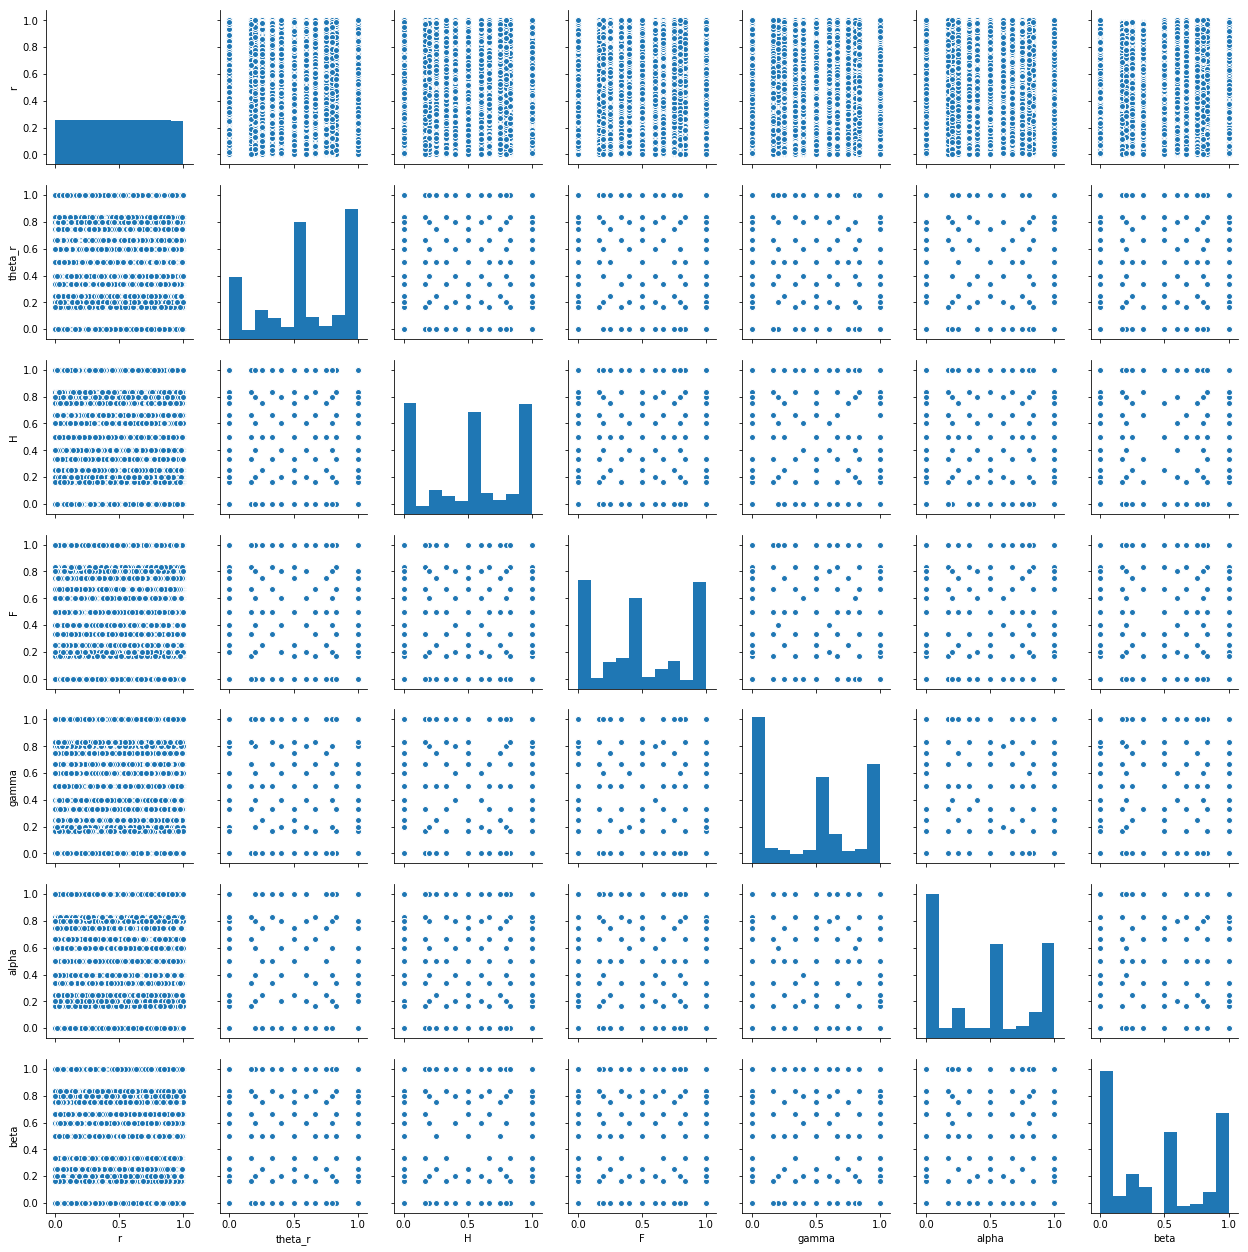

In [8]:
X = df[['r', 'theta_r', 'H', 'F', 'gamma', 'alpha', 'beta']]
sns.pairplot(X);

We can now see that $r$ is uniform distributed over each scenerio.

None of our data exhibits a mixed strategy equilibria (I have reasons to believe we have not checked this correctly though).

We are now checking it correctly. Still for the scenarios that have been performed there is not a mixed
strategy equilibria. 

**Should we collect more data? Can we prove this analytically?**

In [40]:
df[(df["mixed_stable"].isnull() > 0) & (df["mixed_stable"].isnull() < 1)]

,r,theta_r,H,F,gamma,alpha,beta,H*theta_r_r,H*theta_r,indiscriminate_stable,selective_stable,mixed_stable,indiscriminate_evol_stable,selective_evol_stable,mixed_evol_stable


## Indiscriminate poachers

Indiscriminate is always stable in our data (could just be because the parameters have not had time explore the full space).

In [41]:
sum(df["indiscriminate_stable"] == True) / df["indiscriminate_stable"].count()

0.99221021185011482

It is however: never evolutionary stable.

In [42]:
sum(df["indiscriminate_evol_stable"] == True) / df["indiscriminate_stable"].count()

0.0

## Selective poachers

We confirm that selective is however not always stable:

In [43]:
sum(df["selective_stable"] == True) / df["selective_stable"].count()

0.010022325372223383

Never evolutionary stable.

In [44]:
sum(df["selective_evol_stable"] == True) / df["selective_stable"].count()

0.0

TODO: Confirm the equations for testing Selective and Indiscriminate stability.

### Feature importance for selective stability

Let us now apply some basic machine learning to gain information from the multidimensional landscape we have built with our model.

In [45]:
X = df[input_columns]
Y = df["selective_stable"]

In [46]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [47]:
test = SelectKBest(score_func=chi2, k="all")
fit = test.fit(X, Y)

In [48]:
X.columns

Index(['r', 'theta_r', 'H', 'F', 'gamma', 'alpha', 'beta', 'H*theta_r_r',
       'H*theta_r'],
      dtype='object')

In [49]:
pd.DataFrame(list(zip(X.columns, fit.scores_)))

,0,1
0,r,6.289100e+02
1,theta_r,1.587865e-04
2,H,6.985209e-07
3,F,3.771214e-07
4,gamma,6.633240e-05
5,alpha,3.269689e-05
6,beta,7.375679e-04
7,H*theta_r_r,1.814980e+02
8,H*theta_r,8.863466e-05


We see that the biggest predictor as to whether or not activing selective is stable is $H$: constant associated with the value of the full horn. Let us use recursive feature selection to identify/remove components that might have an effect based on cross correlations:

What if we were to selection

In [50]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# feature extraction
model = LogisticRegression()

supports = []
for number_of_variables in range(1, len(input_columns)):
    rfe = RFE(model, number_of_variables)
    fit = rfe.fit(X, Y)
    supports.append(fit.support_)
pd.DataFrame(list(zip(X.columns, *supports)))

,0,1,2,3,4,5,6,7,8
0,r,True,True,True,True,True,True,True,True
1,theta_r,False,False,False,False,False,True,True,True
2,H,False,False,False,False,False,False,False,False
3,F,False,False,False,True,True,True,True,True
4,gamma,False,False,False,False,True,True,True,True
5,alpha,False,False,False,False,False,False,False,True
6,beta,False,False,False,False,False,False,True,True
7,H*theta_r_r,False,True,True,True,True,True,True,True
8,H*theta_r,False,False,True,True,True,True,True,True


We see that the single most important feature is $r$.

- The top two important features: $r$ and $\theta_r$
- The top three: $r$, $\theta_r$ and $\gamma$

$H$ is in fact not selected until all features are selected. This indicates that it probably cross correlates. (I think)

Let us take a look at Principal component analysis to essentially "redimension" our model:

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
fit = pca.fit(X)
# summarize components
print("Explained Variance: {}".format(fit.explained_variance_ratio_))
pd.DataFrame(list(zip(X.columns, *fit.components_)))

Explained Variance: [ 0.22570123  0.16785058  0.13594015  0.13220945]


,0,1,2,3,4
0,r,0.051419,-0.005990,-0.006637,0.000961
1,theta_r,0.381705,0.124810,-0.201864,-0.091702
2,H,0.611163,-0.204234,0.130236,0.068872
3,F,-0.026011,0.000618,-0.765241,0.228651
4,gamma,0.065415,0.567232,0.382267,-0.356447
5,alpha,0.083990,0.588893,-0.427430,-0.345977
6,beta,0.068901,0.519391,0.163494,0.829297
7,H*theta_r_r,0.323527,-0.032030,-0.017024,-0.003985
8,H*theta_r,0.597252,-0.057742,-0.028413,-0.007811


The first compoonent is almost entirely made up of $H$ and explains 99%. I don't think this helps much or how it corresponds to the rest...

In [52]:
from sklearn.ensemble import ExtraTreesClassifier

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
pd.DataFrame(list(zip(X.columns, model.feature_importances_)))

,0,1
0,r,0.737936
1,theta_r,0.011381
2,H,0.028763
3,F,0.000470
4,gamma,0.000606
5,alpha,0.001421
6,beta,0.000169
7,H*theta_r_r,0.205056
8,H*theta_r,0.014197


The main thing that keep seeming to come back as is the importance of $r$.


Let us fit a model to our data and take a look. First let us just fit a model when using $r$ as the predictor:

In [53]:
model = linear_model.LogisticRegression()
model.fit(X[["r"]], Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
rs = np.linspace(0, 1, 1000)
probabilities = [model.predict_proba([[r]]) for r in rs]

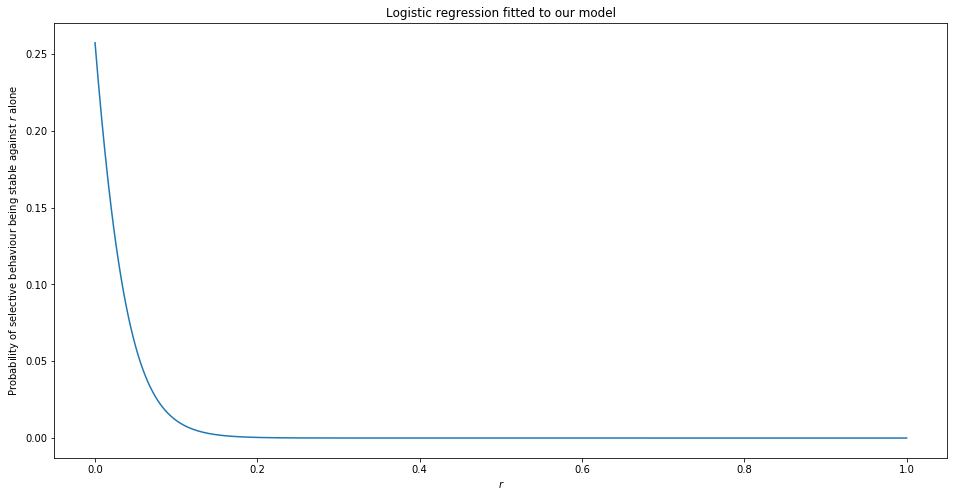

In [55]:
plt.rcParams['figure.figsize'] = 16, 8

plt.plot(rs, [prediction[0][list(model.classes_).index(True)] for prediction in probabilities])
plt.xlabel("$r$")
plt.ylabel("Probability of selective behaviour being stable against $r$ alone")
plt.title("Logistic regression fitted to our model");

Let us take a look at $H$:

In [56]:
model = linear_model.LogisticRegression()
model.fit(X[["H"]], Y)
Hs = np.linspace(0, 1000, 5000)
probabilities = [model.predict_proba([[H]]) for H in Hs]

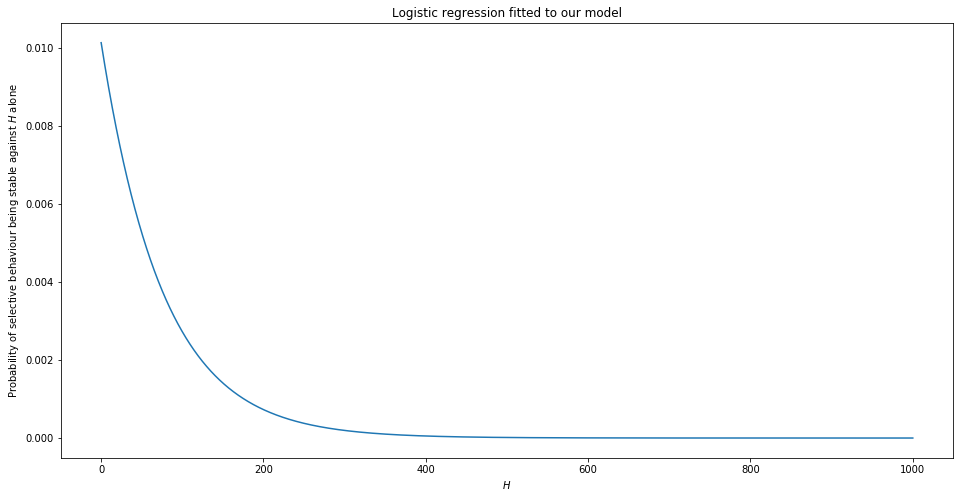

In [57]:
plt.plot(Hs, [prediction[0][list(model.classes_).index(True)] for prediction in probabilities])
plt.xlabel("$H$")
plt.ylabel("Probability of selective behaviour being stable against $H$ alone")
plt.title("Logistic regression fitted to our model");

Let us take a look at the effect of both $H$ and $r$

In [58]:
model = linear_model.LogisticRegression()
model.fit(X[["r", "H"]], Y)
rs = np.linspace(0, 1, 100)
Hs = np.linspace(0, 1000, 100)
probabilities = np.array([[model.predict_proba([[r, H]])[0][list(model.classes_).index(True)] for r in rs] for H in Hs])

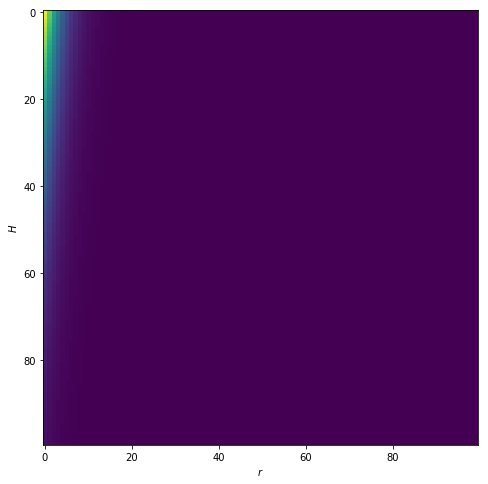

In [59]:
plt.imshow(probabilities)
plt.xlabel("$r$")
plt.ylabel("$H$");

We see that $r$ is the only thing affecting our logistic regression model.

Let us now consider all of the input features.

In [79]:
model = linear_model.LogisticRegression()
model.fit(X.drop(['H*theta_r_r'], axis=1), Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

A number of scenarios in which we will see the effect of $r$


In [80]:
        #  theta_r,  H,  F,, gamma, alpha, beta
    # TODO Need to reverse what the sklearn preprocessor is doing. (
    # To do so need to know what Max, Min was in original df)
scenarios = [[.2, .2, .2, .25, .25, .25],
             [.5, .2, .2, .25, .25, .25],
             [.8, .2, .2, .25, .25, .25],
             [.2, .4, .4, .25, .25, .25],
             [.2, .6, .7, .25, .25, .25],
             [.8, .8, .7, .25, .25, .25]]

In [82]:
[scenario.append(scenario[0] * scenario[1]) for scenario in scenarios]

[None, None, None, None, None, None]

In [84]:
probabilities = [model.predict_proba([[r] + scenario for scenario in scenarios]) for r in rs]

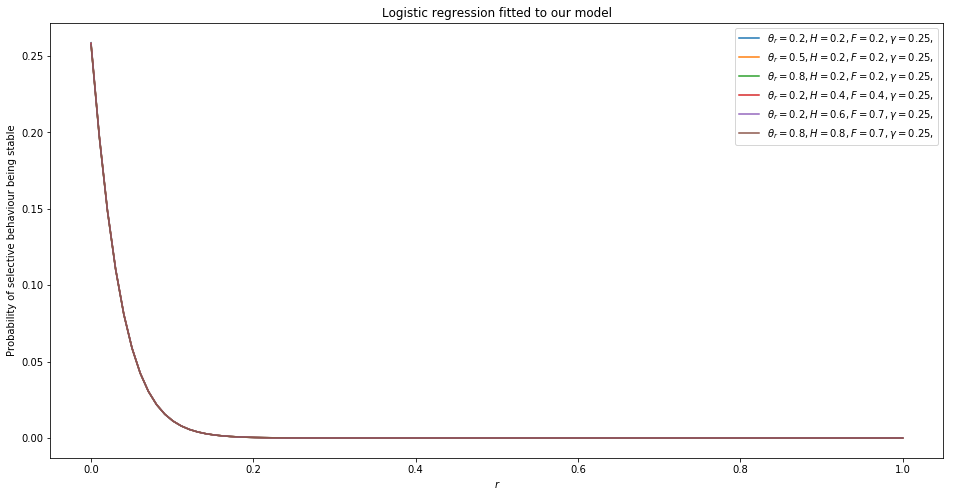

In [85]:
plt.rcParams['figure.figsize'] = 16, 8
for i, scenario in enumerate(scenarios):
    plt.plot(rs, [prediction[i][list(model.classes_).index(True)] for prediction in probabilities],
             label="$\\theta_r={},  H={},  F={}, \gamma={}, \alpha={}, \beta={}$".format(*scenario))
plt.legend()
plt.xlabel("$r$")
plt.ylabel("Probability of selective behaviour being stable")
plt.title("Logistic regression fitted to our model");

Let us try a different predictive classifier, a decision tree:

In [88]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X.drop(['H*theta_r_r'], axis=1), Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

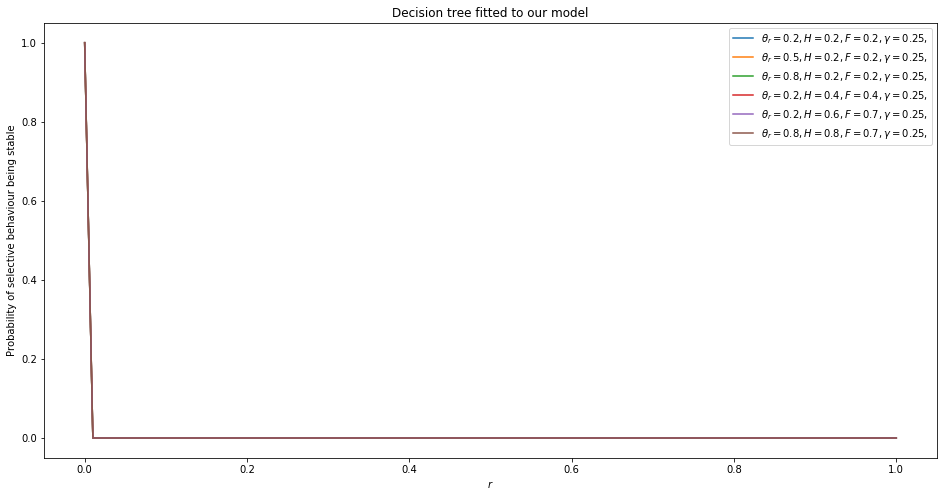

In [89]:
probabilities = [model.predict_proba([[r] + scenario for scenario in scenarios]) for r in rs]
plt.rcParams['figure.figsize'] = 16, 8
for i, scenario in enumerate(scenarios):
    plt.plot(rs, [prediction[i][list(model.classes_).index(True)] for prediction in probabilities],
             label="$\\theta_r={},  H={},  F={}, \gamma={}, \alpha={}, \beta={}$".format(*scenario))
plt.legend()
plt.xlabel("$r$")
plt.ylabel("Probability of selective behaviour being stable")
plt.title("Decision tree fitted to our model");

Random tree:

In [92]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X.drop(['H*theta_r_r'], axis=1), Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

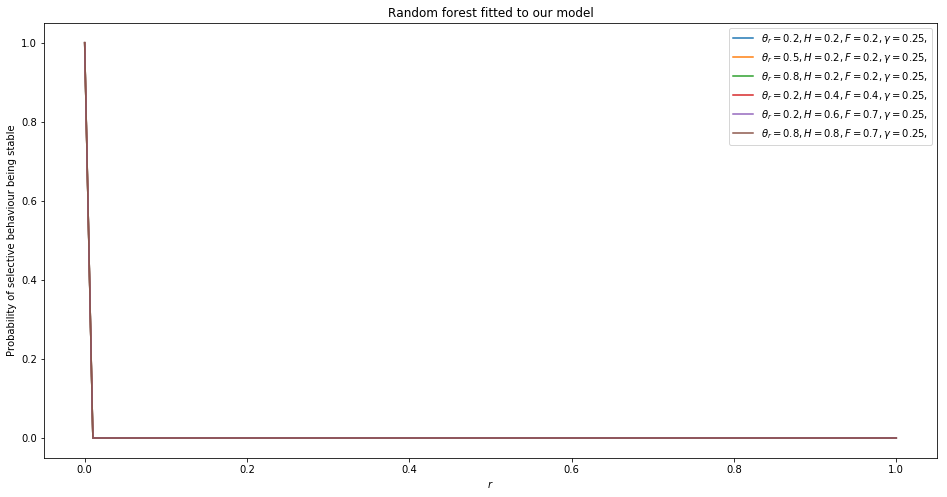

In [93]:
probabilities = [model.predict_proba([[r] + scenario for scenario in scenarios]) for r in rs]
plt.rcParams['figure.figsize'] = 16, 8
for i, scenario in enumerate(scenarios):
    plt.plot(rs, [prediction[i][list(model.classes_).index(True)] for prediction in probabilities],
             label="$\\theta_r={},  H={},  F={}, \gamma={}, \alpha={}, \beta={}$".format(*scenario))
plt.legend()
plt.xlabel("$r$")
plt.ylabel("Probability of selective behaviour being stable")
plt.title("Random forest fitted to our model");

## Summary

- $r$ is the only thing that (really) affects the probability of stability.
- $r\approx .1$ seems to be a cutoff point at which we will no longer have a stable situation.
- Sadly around $r\approx .1$ we will not have a large number of rhinos saved.

To do:

- Tidy the data and perhaps remove nonsense parameters? (If there are any, discuss with Tamsin).
- Rerun with normalised parameters and with extra transformed variables: $H\theta_r r$ and $H\theta_r$ ...
- Rerun the sweep looking at evolutionary stability